<a href="https://colab.research.google.com/github/shyamsparrow/Jan-G4---NLP-Chatbot/blob/Models/Capstone_NLP_Chatbot_Jan_A_G4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - NLP Chatbot

### DOMAIN: 
Industrial safety. NLP based Chatbot.

### CONTEXT:
The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

### DATA DESCRIPTION:
This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence of an accident.

### Columns description:
* Data: timestamp or time/date information
* Countries: which country the accident occurred (anonymised)
* Local: the city where the manufacturing plant is located (anonymised)
* Industry sector: which sector the plant belongs to
* Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
* Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have   been (due to other factors involved in the accident)
* Gender: if the person is male of female
* Employee or Third Party: if the injured person is an employee or a third party
* Critical Risk: some description of the risk involved in the accident
* Description: Detailed description of how the accident happened.

Link to download the dataset: https://drive.google.com/file/d/1_GmrRP1S2OIa02KlfOBNkYa8uxazGbfE/view?usp=sharing,
Original dataset link: https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database

### PROJECT OBJECTIVE:
Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident description.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replace the folder path with your drive folder path and clone the githb repo

In [2]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


Run the below code for clone the repo in our Googele drive for first time

In [3]:
! git clone https://github.com/shyamsparrow/Jan-G4---NLP-Chatbot.git

fatal: destination path 'Jan-G4---NLP-Chatbot' already exists and is not an empty directory.


Change the Current folder into Github repo main folder, all the functions we are calling has to be in this repo.

In [4]:
%cd /content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot

/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot


In [5]:
!git config --global user.email "vegetashyam@gmail.com"
!git config --global user.name "Shyam"

In [6]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	__pycache__/
	model.json
	model.png

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git commit -m "My message"

[main a349dde] My message


Run this code to update the changes in repo to our drive

In [7]:
!git pull

remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/shyamsparrow/Jan-G4---NLP-Chatbot
   0905c37..2ac0f4b  Models     -> origin/Models
Already up to date.


In [8]:
import warnings
warnings.filterwarnings('ignore')

import config
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [26]:
url = "Data Set - industrial_safety_and_health_database_with_accidents_description.csv"
industry_df = pd.read_csv(url, index_col = 0)
industry_df.head

<bound method NDFrame.head of                     Data  ...                                        Description
0    2016-01-01 00:00:00  ...  While removing the drill rod of the Jumbo 08 f...
1    2016-01-02 00:00:00  ...  During the activation of a sodium sulphide pum...
2    2016-01-06 00:00:00  ...  In the sub-station MILPO located at level +170...
3    2016-01-08 00:00:00  ...  Being 9:45 am. approximately in the Nv. 1880 C...
4    2016-01-10 00:00:00  ...  Approximately at 11:45 a.m. in circumstances t...
..                   ...  ...                                                ...
434  2017-07-04 00:00:00  ...  Being approximately 5:00 a.m. approximately, w...
435  2017-07-04 00:00:00  ...  The collaborator moved from the infrastructure...
436  2017-07-05 00:00:00  ...  During the environmental monitoring activity i...
437  2017-07-06 00:00:00  ...  The Employee performed the activity of strippi...
438  2017-07-09 00:00:00  ...  At 10:00 a.m., when the assistant cleaned the ..

In [27]:
industry_df.shape

(425, 10)

### Re-naming the column name:
We have 10 columns( features) and 425 rows of data. Let us Rename the column correctly, which is misspelled.

In [29]:
industry_df.rename(columns={'Data':'Date', 'Countries':'Country', 'Genre':'Gender', 'Employee or Third Party':'Employee_type',
'Industry Sector':'Industry_Sector','Accident Level':'Accident_Level','Potential Accident Level':'Potential_Accident_Level',
'Critical Risk':'Critical_Risk'}, inplace=True)
industry_df.head(3)

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...


### Checking Missing Values:

In [30]:
datatype = pd.DataFrame(industry_df.dtypes)
datatype['MissingVal'] = industry_df.isnull().sum()
datatype['NUnique']=industry_df.nunique()
datatype

,0,MissingVal,NUnique
Date,object,0,287
Country,object,0,3
Local,object,0,12
Industry_Sector,object,0,3
Accident_Level,object,0,5
Potential_Accident_Level,object,0,6
Gender,object,0,2
Employee_type,object,0,3
Critical_Risk,object,0,33
Description,object,0,411


By Checking the missing value, we have 0 missing values in all 10 columns.

### Removing Duplicates:

In [31]:
industry_df.duplicated().sum()

7

We have 7 duplicate values, let us check those values and remove it

In [32]:
duplicates = industry_df.duplicated()
industry_df[duplicates]

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description
89,2016-04-01 00:00:00,Country_01,Local_01,Mining,I,V,Male,Third Party (Remote),Others,In circumstances that two workers of the Abrat...
276,2016-12-01 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Employee,Others,During the activity of chuteo of ore in hopper...
317,2017-01-21 00:00:00,Country_02,Local_02,Mining,I,I,Male,Third Party (Remote),Others,Employees engaged in the removal of material f...
359,2017-03-02 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,On 02/03/17 during the soil sampling in the re...
360,2017-03-02 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,On 02/03/17 during the soil sampling in the re...
369,2017-03-15 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,Team of the VMS Project performed soil collect...
411,2017-05-23 00:00:00,Country_01,Local_04,Mining,I,IV,Male,Third Party,Projection of fragments,In moments when the 02 collaborators carried o...


In [33]:
industry_df.drop_duplicates(inplace=True)
industry_df.shape

(418, 10)

In [34]:
industry_df["Description"].nunique()

411

One can observe in the above dataframe that there are only 411 unique values in the Description column but we have 418 number of records in total, we can assume that there are still 7 number of duplicate values on description column. We will check for those duplicates on column level and drop if required for further analysis.

In [35]:
print('There are still {} duplicates in the dataset as below'.format(industry_df.duplicated(subset=['Description'],keep=False).sum()))
industry_df[industry_df.duplicated(subset=['Description'],keep=False)].sort_values(by='Description')


There are still 14 duplicates in the dataset as below


,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description
180,2016-07-07 00:00:00,Country_01,Local_03,Mining,IV,V,Male,Third Party,Others,At moments when the MAPERU truck of plate F1T ...
181,2016-07-07 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,Others,At moments when the MAPERU truck of plate F1T ...
275,2016-12-01 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Employee,Others,During the activity of chuteo of ore in hopper...
277,2016-12-01 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,Others,During the activity of chuteo of ore in hopper...
426,2017-06-20 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Employee,Others,"In circumstance, the AHK-903 license plate (Em..."
427,2017-06-20 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Others,"In circumstance, the AHK-903 license plate (Em..."
142,2016-05-26 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Bees,"In the geological reconnaissance activity, in ..."
143,2016-05-26 00:00:00,Country_03,Local_10,Others,I,I,Male,Employee,Others,"In the geological reconnaissance activity, in ..."
155,2016-06-08 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Bees,Project of Vazante that carried out sediment c...
156,2016-06-08 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Others,Project of Vazante that carried out sediment c...


We can cleary observe that the above dataframe contains 7 duplicates in which only one or two column values are dissimilar among the datapoints where in the Description is matching, which is logically unsound.
It can also be noticed that the incidents which are having duplicate values happened on the time stamp(Date Column).
Hence we will be dropping these hidden duplicates which doesn't seem right logically.

In [36]:
# Dropping the duplicates we detected above.
industry_df.drop_duplicates(subset=['Description'], keep='first', inplace=True)
print('After removing duplicates the shape of the dataset is:', industry_df.shape)

After removing duplicates the shape of the dataset is: (411, 10)


### Checking Outliers:

In [37]:
for x in industry_df.columns:
    if x != 'Description' and x != 'Date':
        print('--'*30); print(f'Unique values of "{x}" column'); print('--'*30)
        print(industry_df[x].unique())
        print("\n")

------------------------------------------------------------
Unique values of "Country" column
------------------------------------------------------------
['Country_01' 'Country_02' 'Country_03']


------------------------------------------------------------
Unique values of "Local" column
------------------------------------------------------------
['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12']


------------------------------------------------------------
Unique values of "Industry_Sector" column
------------------------------------------------------------
['Mining' 'Metals' 'Others']


------------------------------------------------------------
Unique values of "Accident_Level" column
------------------------------------------------------------
['I' 'IV' 'III' 'II' 'V']


------------------------------------------------------------
Unique values of "Potential_Accident_Level" column
------------

By checking all the unique values of all columns in the dataset, we can say there is no Outlier in this column. 

We have only 3 countries, 12 Locals, 3 Industry sectors, 5 accident levels, 6 potential accident levels, 3 Employee types and 33 Critical Risks including Not applicable.

Five type of accident levels (1 to 5) are present.
Six type of Potential Accident Levels (1 to 6) and we see that there is only one value registered under 'Accident level 6'

In [38]:
industry_df['Potential_Accident_Level'] = industry_df['Potential_Accident_Level'].replace('VI', 'V')

In [39]:
industry_df = industry_df.reset_index(drop=True)

Removed all Duplicate values

In [40]:
industry_df.describe()

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description
count,411,411,411,411,411,411,411,411,411,411
unique,287,3,12,3,5,5,2,3,33,411
top,2017-02-08 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,Others,The employee was working in the When a thermal...
freq,6,245,87,232,303,138,390,180,223,1


We have 411 unique descriptions in the dataset.

In [41]:
print(industry_df.Date.min())
print(industry_df.Date.max())

2016-01-01 00:00:00
2017-07-09 00:00:00


The Accidents are captured in the year 2016- January to 2017 July. ~ 19 months of data.

Let us split the date value into year, month, day, name of the day and week of the year.

In [43]:
industry_df['Date'] = pd.to_datetime(industry_df['Date'])
industry_df['Year'] = industry_df['Date'].apply(lambda x : x.year)
industry_df['Month'] = industry_df['Date'].apply(lambda x : x.month)
industry_df['Day'] = industry_df['Date'].apply(lambda x : x.day)
industry_df['Weekday'] = industry_df['Date'].apply(lambda x : x.day_name())
industry_df['WeekofYear'] = industry_df['Date'].apply(lambda x : x.weekofyear)
industry_df.head(3)

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description,Year,Month,Day,Weekday,WeekofYear
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,53
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,53
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,1


Accordin to this discussion, countries where the dataset was collected is anonymized but they are all located in South America. So in this analysis, let's assume the dataset was collected in Brazil.
It is said in this web page that Brazil has four climatological seasons as below.

*   Spring : September to November
*   Summer : December to February
*   Autumn : March to May
*   Winter : June to August

We can create seasonal variable based on month variable.


In [44]:
def month2seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season

In [45]:
industry_df['Season'] = industry_df['Month'].apply(month2seasons)
industry_df.head(3)

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description,Year,Month,Day,Weekday,WeekofYear,Season
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,53,Summer
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,53,Summer
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,1,Summer


Let us check the time date and the spread of data across time.

In [46]:
year_data = pd.DataFrame(industry_df.dtypes)
year_data['NUnique']=industry_df.nunique()
year_data.iloc[10:16]

,0,NUnique
Year,int64,2
Month,int64,12
Day,int64,31
Weekday,object,7
WeekofYear,int64,53
Season,object,4


In [47]:
datelist = ['Year','Month','Day','Weekday','Season']
for x in datelist:
    print('--'*30); print(f'Unique values of "{x}" column'); print('--'*30)
    print(industry_df[x].unique())
    print("\n")

------------------------------------------------------------
Unique values of "Year" column
------------------------------------------------------------
[2016 2017]


------------------------------------------------------------
Unique values of "Month" column
------------------------------------------------------------
[ 1  2  3  4  5  6  7  8  9 10 11 12]


------------------------------------------------------------
Unique values of "Day" column
------------------------------------------------------------
[ 1  2  6  8 10 12 16 17 19 26 28 30  4  7 21 25  9 15 14 13 20 18 22 24
 29 27  3  5 11 31 23]


------------------------------------------------------------
Unique values of "Weekday" column
------------------------------------------------------------
['Friday' 'Saturday' 'Wednesday' 'Sunday' 'Tuesday' 'Thursday' 'Monday']


------------------------------------------------------------
Unique values of "Season" column
------------------------------------------------------------
['S

* We have accidents happened between 2016 to 2017 as per year column.
* The accidents is spread across all months, days and weekday.

Install pyspellchecker library for spell check.

In [48]:
!pip install contractions
!pip install pyspellchecker
verbose= False

     |████████████████████████████████| 284 kB 11.8 MB/s 
     |████████████████████████████████| 321 kB 84.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85460 sha256=b9edd18de78c65aafaec9e13f89f2ccefb71ad00080b4d1bd3991cac0cab6593
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 2.7 MB 12.2 MB/s 


We created a NLP_text_preprocess.py file and added all our preprocess steps there, from the config file we are passing the flags to our class PreProcessing in our python file.

We are doing the following steps for our preprocessing.

* Convert into Lower case
* Removing the URl
* Removing the Special characters
* Removing Punctuation
* Removing Whitespaces
* Check the spelling mistakes
* Removing the stopwords
* Convert the words into lemma form

In [49]:
from NLP_text_preprocess import PreProcessing

In [50]:
pp = PreProcessing(to_lower = config.to_lower,remove_url=config.remove_url,
                   remove_time = config.remove_time,expand_contraction =config.expand_contraction,
                   remove_special_character=config.remove_special_character,
                   remove_punctuation=config.remove_punctuation,
                   remove_whitespace=config.remove_whitespace,
                   keep_alpha_numeric = False,
                   check_spelling=config.check_spelling,
                   remove_stopword=config.remove_stopword,
                   lemmatize_word=config.lemmatize_word)

pp.preprocess(industry_df.Description[1])

'activation sodium sulphide pump piping uncoupled sulfide solution designed area reach maid immediately made use emergency shower directed ambulatory doctor later hospital note sulphide solution 48 gram liter'

We Preprocess the entire description column and save it in Description_preprocessed.

In [51]:
industry_df['Description_preprocessed'] = industry_df.Description.apply(lambda x: pp.preprocess(x))

In [52]:
industry_df.head()

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description,Year,Month,Day,Weekday,WeekofYear,Season,Description_preprocessed
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,53,Summer,removing drill rod jumbo 08 maintenance superv...
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,53,Summer,activation sodium sulphide pump piping uncoupl...
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,1,Summer,substation milo located level 170 collaborator...
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8,Friday,1,Summer,approximately 1880 cx695 ob personnel begin ta...
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10,Sunday,1,Summer,approximately circumstance mechanic anthony gr...


In [53]:
industry_df.to_csv('industry_df_preprocessed.csv', index=False)

In [54]:
industry_df = pd.read_csv("industry_df_preprocessed.csv")

In [63]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pickle

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, LSTM,  Embedding, Dropout, Bidirectional, GlobalMaxPool1D

from keras.utils import np_utils
from keras.layers.merge import Concatenate
#from keras.utils import plot_model

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Keras pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [28]:
# Select input and output features

X_text = industry_df['Description_preprocessed']
y_text = industry_df['Potential Accident Level']

In [29]:
# Encode labels in column 'Potential Accident Level'and Convert into one-hot encoded vectors:
y_text = LabelEncoder().fit_transform(y_text)
y_text = np_utils.to_categorical(y_text)

In [32]:
# Divide our data into testing and training sets:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size = 0.20, random_state = 1)

print('X_text_train shape : ({0})'.format(X_text_train.shape))
print('y_text_train shape : ({0},)'.format(y_text_train.shape))
print('X_text_test shape : ({0})'.format(X_text_test.shape))
print('y_text_test shape : ({0},)'.format(y_text_test.shape))

X_text_train shape : ((334,))
y_text_train shape : ((334, 6),)
X_text_test shape : ((84,))
y_text_test shape : ((84, 6),)


In [33]:
y_text_train.shape,y_text_test.shape

((334, 6), (84, 6))

In [34]:
industry_df['nb_words'] = industry_df['Description_preprocessed'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(industry_df['nb_words'].min()))
print('Maximum number of words: {}'.format(industry_df['nb_words'].max()))

Minimum number of words: 9
Maximum number of words: 99


In [35]:
# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_text_train)

X_text_train = tokenizer.texts_to_sequences(X_text_train)
X_text_test = tokenizer.texts_to_sequences(X_text_test)

In [36]:
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 100

X_text_train = pad_sequences(X_text_train, padding='post', maxlen=maxlen)
X_text_test = pad_sequences(X_text_test, padding='post', maxlen=maxlen)

vocab_size: 2741


In [48]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-12-05 06:24:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-05 06:24:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-05 06:24:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [49]:
!ls
!pwd

'AIML Capstone Project - NLP chatbot.pdf'
 Capstone_NLP_Chatbot_Jan_A_G4.ipynb
 Chatbot.ipynb
 config.py
 data
'Data Set - industrial_safety_and_health_database_with_accidents_description.csv'
'GL Bot.json'
 glove.6B.100d.txt
 glove.6B.200d.txt
 glove.6B.300d.txt
 glove.6B.50d.txt
 glove.6B.zip
 industry_df_preprocessed.csv
 NLP_text_preprocess.py
 Pradeebha_Capstone_NLP_Chatbot_Jan_A_G4.ipynb
 __pycache__
 README.md
/content/drive/My Drive/AIML/Capstone/Jan-G4---NLP-Chatbot


In [50]:
print('Indexing word vectors.')

embeddings_dictionary = {}
f = open('glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_dictionary))

Indexing word vectors.
Found 400000 word vectors.


In [55]:
import pickle
pickle.dump({'embeddings_dictionary' : embeddings_dictionary } , open('/content/drive/MyDrive/AIML/Capstone/embeddings_dictionary.pickle', 'wb'))

In [38]:
import pickle
infile = open('/content/drive/MyDrive/AIML/Capstone/embeddings_dictionary.pickle','rb')
embeddings_dictionary = pickle.load(infile)

In [39]:
embedding_size = 200

embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

(2741, 200)

In [40]:
base_model = Sequential()
base_model.add(Embedding(vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=100, trainable=True))
#LSTM 
base_model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
base_model.add(Dense(6, activation='sigmoid'))
base_model.compile(optimizer=optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [41]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          548200    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              336896    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 886,638
Trainable params: 886,638
Non-trainable params: 0
_________________________________________________________________


In [42]:
X_text_train.shape,y_text_train.shape,X_text_test.shape, y_text_test.shape

((334, 100), (334, 6), (84, 100), (84, 6))

In [44]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.001)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=5, min_delta=1E-4)

# fit the keras model on the dataset
base_model_history = base_model.fit(X_text_train, y_text_train, epochs=20, batch_size=8, verbose=1, validation_data=(X_text_test, y_text_test), callbacks=[rlrp])

Epoch 1/20
42/42 [==============================] - 24s 566ms/step - loss: 0.0594 - acc: 0.9311 - val_loss: 0.9095 - val_acc: 0.3214 - lr: 0.0100
Epoch 2/20
42/42 [==============================] - 24s 566ms/step - loss: 0.1176 - acc: 0.8802 - val_loss: 0.8386 - val_acc: 0.3214 - lr: 0.0100
Epoch 3/20
42/42 [==============================] - 23s 553ms/step - loss: 0.1805 - acc: 0.8084 - val_loss: 0.6646 - val_acc: 0.4286 - lr: 0.0100
Epoch 4/20
42/42 [==============================] - 23s 558ms/step - loss: 0.2062 - acc: 0.7784 - val_loss: 0.7047 - val_acc: 0.3929 - lr: 0.0100
Epoch 5/20
42/42 [==============================] - 24s 569ms/step - loss: 0.2742 - acc: 0.7186 - val_loss: 0.6970 - val_acc: 0.3810 - lr: 0.0100
Epoch 6/20
42/42 [==============================] - 23s 556ms/step - loss: 0.2464 - acc: 0.7066 - val_loss: 0.6832 - val_acc: 0.3690 - lr: 0.0100
Epoch 7/20
42/42 [==============================] - 23s 537ms/step - loss: 0.2466 - acc: 0.6856 - val_loss: 0.6431 - val_acc

In [46]:
_, train_accuracy = base_model.evaluate(X_text_train, y_text_train, batch_size=8, verbose=0)
_, test_accuracy = base_model.evaluate(X_text_test, y_text_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 84.43
Test accuracy: 38.10


In [72]:
# get the accuracy, precision, recall, f1 score from model
def get_classification_metrics(model, X_test, y_test, target_type):
  
  # predict probabilities for test set
  yhat_probs = model.predict(X_test, verbose=0) # Multiclass

  # predict crisp classes for test set
  if target_type == 'multi_class':
    yhat_classes = model.predict_classes(X_test, verbose=0) # Multiclass
  else:
    yhat_classes = (np.asarray(model.predict(X_test))).round() # Multilabel

  # reduce to 1d array
  yhat_probs = yhat_probs[:, 0]

  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test, yhat_classes)

  # precision tp / (tp + fp)
  precision = precision_score(y_test, yhat_classes, average='micro')

  # recall: tp / (tp + fn)
  recall = recall_score(y_test, yhat_classes, average='micro')

  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test, yhat_classes, average='micro')

  return accuracy, precision, recall, f1

In [48]:
class Metrics(tf.keras.callbacks.Callback):

    def __init__(self, validation_data=()):
        super().__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        xVal, yVal, target_type = self.validation_data
        if target_type == 'multi_class':
          val_predict_classes = model.predict_classes(xVal, verbose=0) # Multiclass
        else:
          val_predict_classes = (np.asarray(self.model.predict(xVal))).round() # Multilabel
        
        
        val_targ = yVal

        _val_f1 = f1_score(val_targ, val_predict_classes, average='micro')
        _val_recall = recall_score(val_targ, val_predict_classes, average='micro')
        _val_precision = precision_score(val_targ, val_predict_classes, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        #print("— train_f1: %f — train_precision: %f — train_recall %f" % (_val_f1, _val_precision, _val_recall))
        return

In [59]:
# Build a LSTM Neural Network
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=True)(deep_inputs)

LSTM_Layer_1 = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
max_pool_layer_1 = GlobalMaxPool1D()(LSTM_Layer_1)
drop_out_layer_1 = Dropout(0.5, input_shape = (256,))(max_pool_layer_1)
dense_layer_1 = Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2 = Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2 = Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3 = Dropout(0.5, input_shape = (64,))(dense_layer_2)

dense_layer_3 = Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4 = Dropout(0.5, input_shape = (32,))(dense_layer_3)

dense_layer_4 = Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = Dropout(0.5, input_shape = (10,))(dense_layer_4)

dense_layer_5 = Dense(6, activation='softmax')(drop_out_layer_5)

lstm_model = Model(inputs=deep_inputs, outputs=dense_layer_5)

opt = optimizers.Adam(lr = 0.001)
lstm_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [60]:
print(lstm_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 200)          548200    
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 256)         336896    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               3289

In [53]:
!pip install plot_model

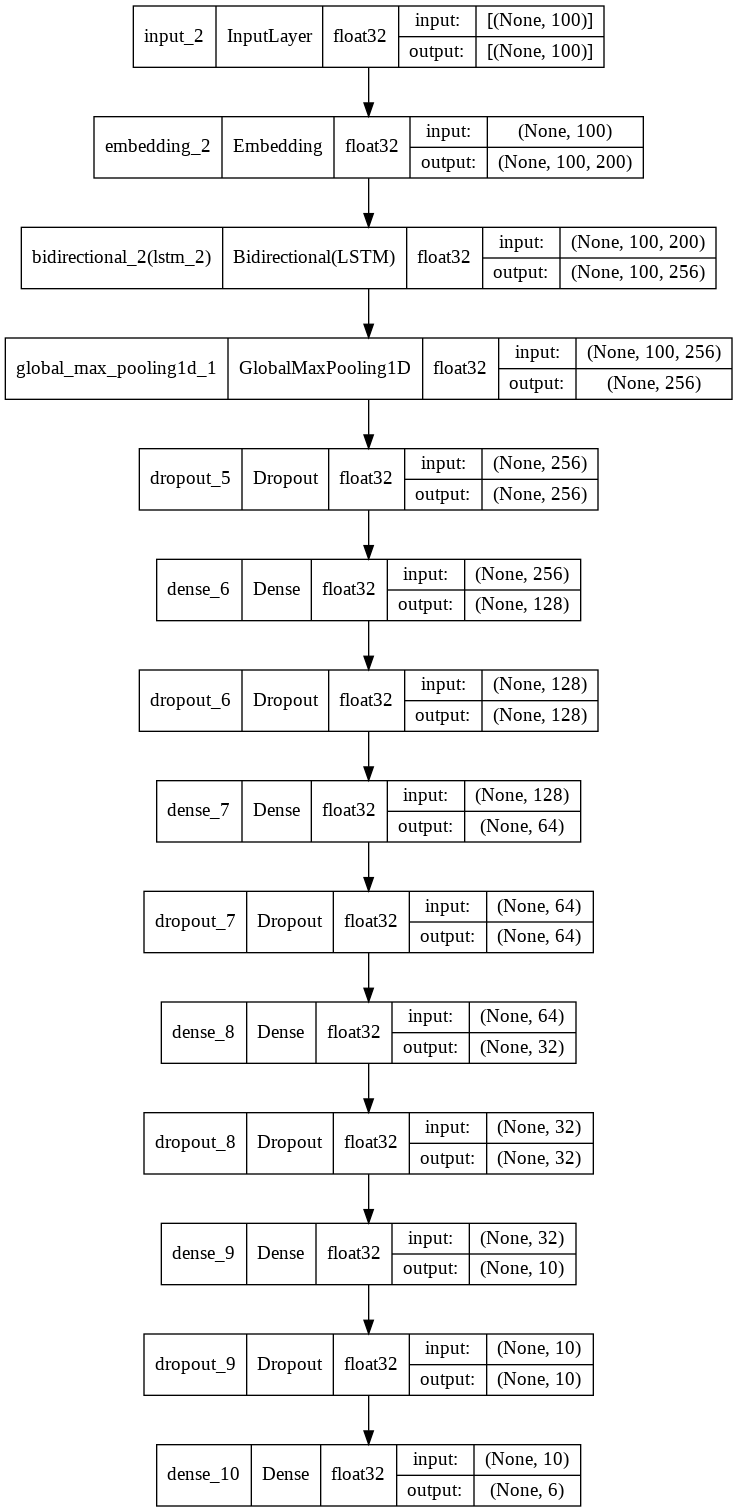

In [61]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(lstm_model, to_file='model.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [64]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=1E-2)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_delta=1E-3)

target_type = 'multi_label'
metrics = Metrics(validation_data=(X_text_train, y_text_train, target_type))

# fit the keras model on the dataset
training_history = lstm_model.fit(X_text_train, y_text_train, epochs=100, batch_size=8, verbose=1, validation_data=(X_text_test, y_text_test), callbacks=[rlrp, metrics])

Epoch 1/100
42/42 [==============================] - 9s 206ms/step - loss: 1.7656 - acc: 0.3323 - val_loss: 1.7551 - val_acc: 0.3571 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - 9s 205ms/step - loss: 1.7496 - acc: 0.3323 - val_loss: 1.7379 - val_acc: 0.3571 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - 9s 211ms/step - loss: 1.7345 - acc: 0.3323 - val_loss: 1.7225 - val_acc: 0.3571 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - 9s 207ms/step - loss: 1.7206 - acc: 0.3323 - val_loss: 1.7074 - val_acc: 0.3571 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - 9s 205ms/step - loss: 1.7072 - acc: 0.3323 - val_loss: 1.6947 - val_acc: 0.3571 - lr: 0.0010
Epoch 6/100
42/42 [==============================] - 9s 205ms/step - loss: 1.6952 - acc: 0.3323 - val_loss: 1.6811 - val_acc: 0.3571 - lr: 0.0010
Epoch 7/100
42/42 [==============================] - 9s 204ms/step - loss: 1.6837 - acc: 0.3323 - val_loss: 1.6694 - val_acc

In [71]:
# evaluate the keras model
_, train_accuracy = lstm_model.evaluate(X_text_train, y_text_train, batch_size=8, verbose=0)
_, test_accuracy = lstm_model.evaluate(X_text_test, y_text_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 33.23
Test accuracy: 35.71


In [73]:
accuracy, precision, recall, f1 = get_classification_metrics(lstm_model, X_text_test, y_text_test, target_type)
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

Accuracy: 0.000000
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


Text(0.5, 1.0, 'Training and validation loss')

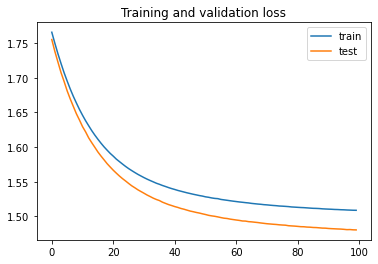

In [67]:
epochs = range(len(training_history.history['loss'])) # Get number of epochs

# plot loss learning curves
plt.plot(epochs, training_history.history['loss'], label = 'train')
plt.plot(epochs, training_history.history['val_loss'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

Text(0.5, 1.0, 'Training and validation accuracy')

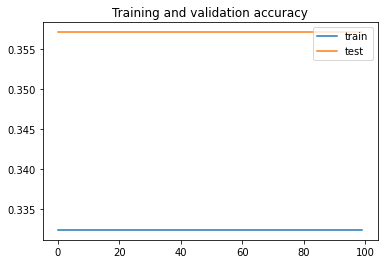

In [68]:
# plot accuracy learning curves
plt.plot(epochs, training_history.history['acc'], label = 'train')
plt.plot(epochs, training_history.history['val_acc'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation accuracy')

In [69]:
lstm_model_json = lstm_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model weights to disk")

# Save the model in h5 format 
model.save("finalized_keras_model.h5")
print("Saved model to disk")

NameError: ignored